In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import napari

In [25]:
"""params"""
input_shape = (9, 11, 11)
hidden_dim = 512
latent_dim = 2

enable_cuda = True


In [55]:
"""VAE code adapted from https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/ """
class VAE(nn.Module):
    """Variational Autoencoder with support for deterministic and probabilistic reconstruction."""
    
    DEFAULT_EPS = 1e-8

    def __init__(self) -> None:
        """Initialize VAE.
        """
        super().__init__()

        # Build encoder: input -> hidden -> latent parameters (mu, sigma)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                int(torch.prod(torch.tensor(input_shape))), hidden_dim
            ),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2),
        )

        # Build decoder: latent -> hidden -> reconstructed input
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(
                hidden_dim, int(torch.prod(torch.tensor(input_shape)))
            ),
            nn.Unflatten(1, input_shape),
        )

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Encode input to latent distribution parameters."""
        encoder_output = self.encoder(x)
        mu, sigma = torch.chunk(encoder_output, 2, dim=-1)
        return mu, sigma

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent representation to reconstruction logits"""
        return self.decoder(z)

    def reparameterize(self, mu: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        """Apply reparameterization trick for differentiable sampling."""
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

    def forward(
        self,
        x: torch.Tensor,
        compute_loss: bool = True,
        reconstruct: bool = False,
        eps: float = DEFAULT_EPS,
    ):
        """Forward pass through the VAE.

        Args:
            x: Input tensor of shape (batch_size, *input_shape)
            compute_loss: Whether to compute VAE loss components
            reconstruct: Whether to return reconstructions or distributions
            eps: Small epsilon value for numerical stability

        Returns:
            tuple of outputs and losses
        """
        # Encode and sample from latent space
        mu, sigma = self.encode(x)
        std = torch.exp(0.5 * sigma)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon

        # Decode latent samples
        x_hat = self.decode(z)

        # Compute losses
        loss, loss_recon, loss_kl = self._compute_loss(
                x, x_hat, mu, sigma, std
            )
            
         # Create output object
        output = (x_hat, z, mu, std, loss_recon, loss_kl, loss)

        return output


    # ==================== Loss Computation ====================

    def _compute_loss(
        self,
        x: torch.Tensor,
        x_hat: torch.Tensor,
        mu: torch.Tensor,
        sigma: torch.Tensor,
        std: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute VAE loss components for deterministic reconstruction."""
        loss_recon = self._compute_reconstruction_loss(x, x_hat)
        loss_kl = self._compute_kl_loss(mu, sigma, std)
        return loss_recon + loss_kl, loss_recon, loss_kl

    def _compute_reconstruction_loss(
        self, x: torch.Tensor, x_hat: torch.Tensor
    ) -> torch.Tensor:
        """Compute reconstruction loss ."""
        return F.mse_loss(x_hat, x, reduction='sum')

    def _compute_kl_loss(
        self,
        mu: torch.Tensor,
        sigma: torch.Tensor,
        std: torch.Tensor,
        eps: float = DEFAULT_EPS,
    ) -> torch.Tensor:
        """Compute KL divergence between latent distribution and standard normal prior."""
        # Analytical KL: KL(N(μ,σ²) || N(0,1)) = 0.5 * Σ(μ² + σ² - 1 - log(σ²))
    
        # sigma represents log-variance parameterization: log(σ²)
        kl_per_sample = 0.5 * torch.sum(mu.pow(2) + sigma.exp() - 1 - sigma, dim=1)

        return kl_per_sample.mean()

In [16]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, transform=None):
        'Initialization'
        self.x = x
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.x[index]

In [22]:
"""Load data"""
# load data
df = pd.read_pickle(r'/media/brandon/Data1/Somitogenesis/Dorado/radial_001/spots_raw.pkl')
probs = df.iloc[:,-1]
data = pd.DataFrame(df[probs < 0.1].data, columns=['data'])
train_data_list = data.data.iloc[:50_000].to_list()
test_data_list = data.data.iloc[50_000:55_000].to_list()

In [23]:
"""Organize data into numpy arrays"""
tmp = [np.expand_dims(d, axis=0) for d in train_data_list]
train_data = np.concatenate(tmp, axis=0)
train_data = train_data.astype('float32')
tmp = [np.expand_dims(d, axis=0) for d in test_data_list]
test_data = np.concatenate(tmp, axis=0)
test_data = test_data.astype('float32')

for i, voxel in enumerate(train_data):
    train_data[i] = (voxel - np.min(voxel)) / (np.max(voxel) - np.min(voxel))

for i, voxel in enumerate(test_data):
    test_data[i] = (voxel - np.min(voxel)) / (np.max(voxel) - np.min(voxel))


In [24]:
# Prepare training data
batch_size = 128
transform = tv.transforms.ToTensor()
train_data = Dataset(train_data, transform=transform)
test_data = Dataset(test_data, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

train_iter = iter(train_loader)

In [56]:
model = VAE()

# Move model on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

model

VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1089, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1089, bias=True)
    (3): Unflatten(dim=1, unflattened_size=(9, 11, 11))
  )
)

In [57]:
# Train model no classes
max_iter = 10_000

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x = next(train_iter)
    
    optimizer.zero_grad()
    x = x.to(device)
    x = x.type(torch.cuda.FloatTensor)
    output = model.forward(x)
    loss = output[-1]
    #print(loss)
        
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.79it/s]


Text(0, 0.5, 'loss')

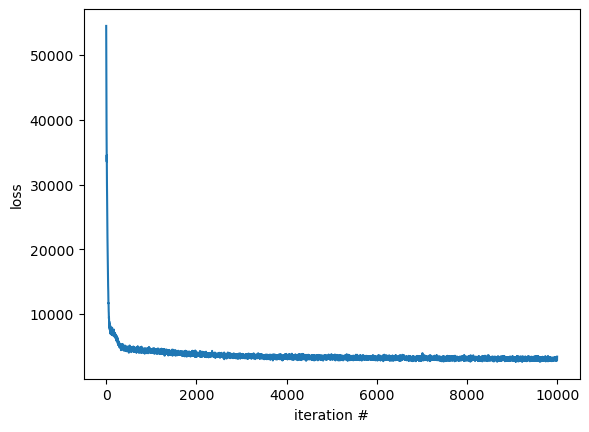

In [113]:
plt.figure()
plt.plot(loss_hist)
plt.yscale('linear')
plt.xlabel('iteration #')
plt.ylabel('loss')

## Generate samples

In [111]:
n_samples = 100
sample_arr = np.zeros((n_samples,) + input_shape)
for n in range(n_samples):
    z = torch.rand(2).unsqueeze(0).to(device)
    sample_arr[n] = model.decode(z).squeeze().cpu().detach().numpy()


In [112]:
viewer = napari.view_image(sample_arr)